# Description of the breast lesion deep learning project

## Motivation and notes

## Publications data sources

Al-Dhabyani, W., Gomaa, M., Khaled, H., & Fahmy, A. (2019). Dataset of breast ultrasound images. Data in brief, 28, 104863. https://doi.org/10.1016/j.dib.2019.104863

Pawłowska, A., Ćwierz-Pieńkowska, A., Domalik, A., Jaguś, D., Kasprzak, P., Matkowski, R., Fura, Ł., Nowicki, A., & Zolek, N. (2024). A Curated Benchmark Dataset for Ultrasound Based Breast Lesion Analysis (Breast-Lesions-USG) (Version 1) [dataset]. The Cancer Imaging Archive. https://doi.org/10.7937/9WKK-Q141

**the following data is not included yet**

A. Abbasian Ardakani, A. Mohammadi, M. Mirza-Aghazadeh-Attari, U.R. Acharya, An open-access breast lesion ultrasound image database‏: Applicable in artificial intelligence studies, Computers in Biology and Medicine, 152 (2023) 106438. https://doi.org/10.1016/j.compbiomed.2022.106438



In [63]:
# Imports
import warnings
warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Data exploration 

## Plotting example images

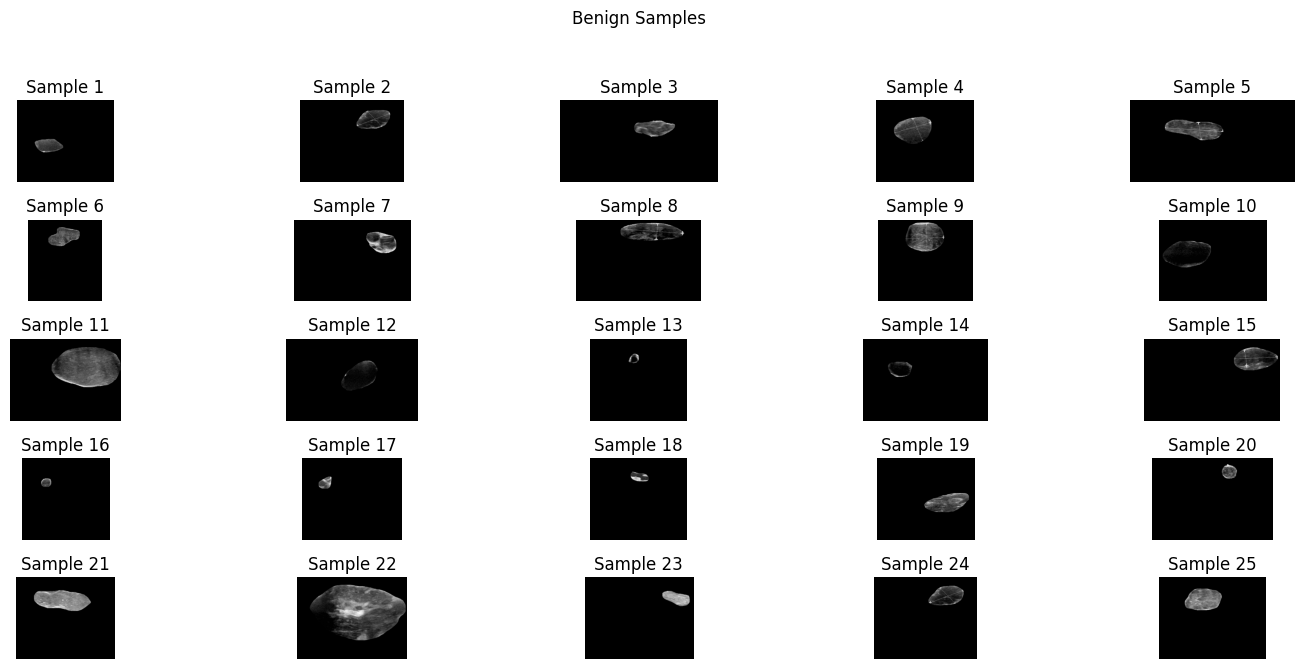

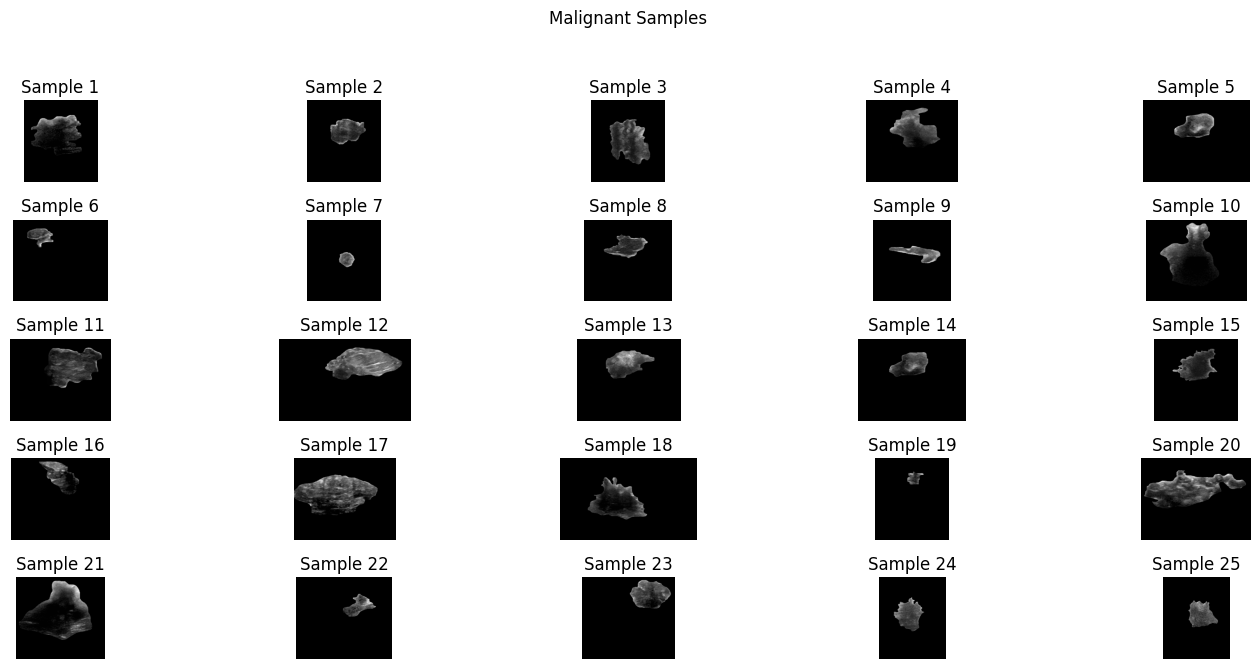

In [64]:
def plot_class_samples(base_path, class_name, num_samples=10):
    plt.figure(figsize=(15, 7))
    class_folder = os.path.join(base_path, class_name)
    image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith('.png')]

    for i in range(min(num_samples, len(image_files))):
        img_path = image_files[i]
        img = Image.open(img_path).convert('L')  # Load in grayscale
        ax = plt.subplot(5, 5, i + 1)  # Adjust subplot grid for 10 images: 2 rows and 5 columns
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Sample {i + 1}")
        ax.axis('off')

    plt.suptitle(f"{class_name.capitalize()} Samples")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
training_path = '/kaggle/input/breast-lesion-dataset2/Breast_lesion_dataset2/Training_data'

plot_class_samples(training_path, 'benign', num_samples=25)

plot_class_samples(training_path, 'malignant', num_samples=25)

In [66]:
def create_classification_df(base_path):
    categories = ['benign', 'malignant'] 
    data = [] 

    for category in categories:
        class_folder = os.path.join(base_path, category)
        # List files in the directory
        image_files = [f for f in os.listdir(class_folder) if f.endswith('.png')]
        
        # Create a list of dictionaries containing the filename and classification
        data.extend([{'filename': f, 'classification': category} for f in image_files])
   
    df = pd.DataFrame(data)
    return df

test_path = '/kaggle/input/breast-lesion-dataset2/Breast_lesion_dataset2/Test_data'
train_df = create_classification_df(training_path)
test_df = create_classification_df(test_path)

df = pd.concat([train_df, test_df])
print(train_df.shape)
print(test_df.shape)
print(df.head())

(799, 2)
(100, 2)
           filename classification
0    benign (2).png         benign
1  benign (285).png         benign
2       case041.png         benign
3  benign (300).png         benign
4  benign (428).png         benign


## Is there a class imbalance? 

In [67]:
print(train_df['classification'].value_counts())
print(test_df['classification'].value_counts())

classification
benign       541
malignant    258
Name: count, dtype: int64
classification
benign       50
malignant    50
Name: count, dtype: int64


# Model building

## Loading data with keras.preprocessing function (tip from Vlad)

In [72]:
training_path = '/kaggle/input/breast-lesion-dataset2/Breast_lesion_dataset2/Training_data'

# parameters for the dataset generation
batch_size = 32
img_height = 224  # what should the input size be? #224
img_width = 224   # ?

# Create training dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='int',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
    validation_split=0.2,  # image proportion for validation
    subset='training',
)

# Crreating validation set
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='int',
    class_names=['benign', 'malignant'],
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)


# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    shuffle=True,
    image_size=(224, 224), 
    color_mode='grayscale', 
    batch_size=32)  


Found 799 files belonging to 2 classes.
Using 640 files for training.
Found 799 files belonging to 2 classes.
Using 159 files for validation.
Found 100 files belonging to 2 classes.


## Data preprocessing and augmentation 

## Edge detection: is it true that benign lesions are rather round and malignant ones are rather irregularly shaped? 

## Inspect Preprocessed Images?

## Baseline model

In [73]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers


model = Sequential()


model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same",input_shape=(img_height, img_width, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )

model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )

model.add(layers.Flatten())

# Here we flatten our data to end up with just one dimension

model.add(layers.Dense(64, activation="relu"))

model.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(dataset,
                    validation_data=validation_dataset,
                    epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/10
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5800 - loss: 3.1913

2024-05-08 09:59:58.281573: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.34364, expected 0.698851
2024-05-08 09:59:58.281626: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.77457, expected 2.12978
2024-05-08 09:59:58.281635: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.06118, expected 2.41638
2024-05-08 09:59:58.281643: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.91208, expected 2.26729
2024-05-08 09:59:58.281650: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.74232, expected 2.09753
2024-05-08 09:59:58.281658: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.5561, expected 1.9113
2024-05-08 09:59:58.281665: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.00193, expected 2.35714
2024-05-08 09:59:58.281673: E external/local_xla/xla/ser

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.5868 - loss: 2.9983 - val_accuracy: 0.6415 - val_loss: 17.2715
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7809 - loss: 0.5427 - val_accuracy: 0.6352 - val_loss: 71.5647
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8276 - loss: 0.4037 - val_accuracy: 0.6667 - val_loss: 82.2162
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8926 - loss: 0.2639 - val_accuracy: 0.6667 - val_loss: 93.1392
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9405 - loss: 0.1530 - val_accuracy: 0.6478 - val_loss: 54.5824
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9632 - loss: 0.0903 - val_accuracy: 0.6101 - val_loss: 118.4506
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9535 - loss: 0.1384 - val_accuracy: 0.6541 - val_loss: 77.4928
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9766 - loss: 0.0814 - val_accuracy: 0.7044 - val

In [74]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


In [75]:
def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()

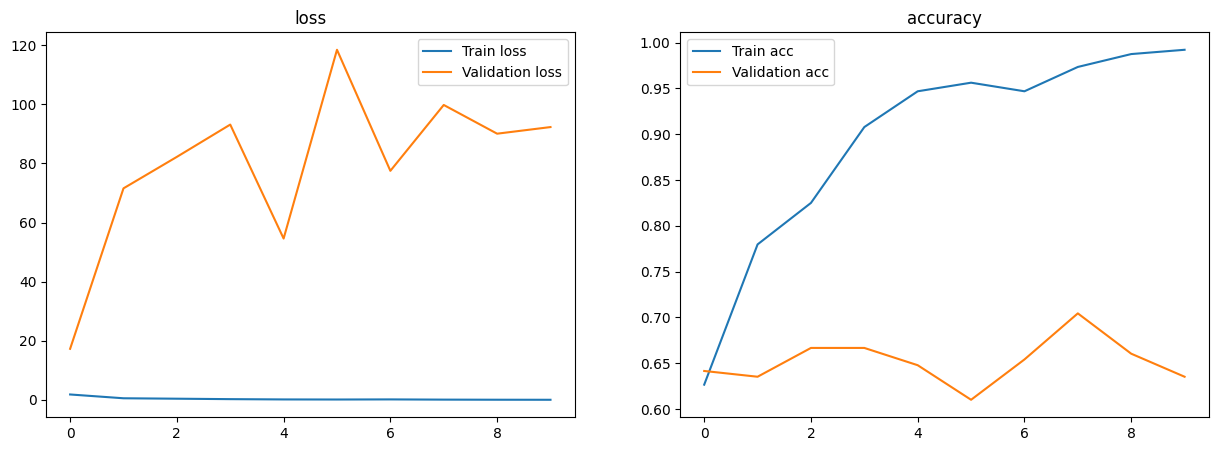

In [76]:
plot_history(history)

## Data Augmentation

In [77]:
model_2 = Sequential()


# Data Augmentation Layers

model_2.add(layers.RandomFlip("horizontal"))
model_2.add(layers.RandomZoom(0.1))
model_2.add(layers.RandomTranslation(0.2, 0.2))
model_2.add(layers.RandomRotation(0.1))



# Convolutional Layers

model_2.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same", input_shape=(img_height, img_width, 1)))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_2.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_2.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_2.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_2.add(layers.Flatten())

model_2.add(layers.Dense(64, activation="relu"))


model_2.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = model_2.fit(dataset,
                    validation_data=validation_dataset,
                    epochs=10)

# Evaluate the model
loss, accuracy = model_2.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5691 - loss: 1.6241 - val_accuracy: 0.7610 - val_loss: 0.6201
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6837 - loss: 0.6295 - val_accuracy: 0.6792 - val_loss: 0.6383
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7017 - loss: 0.6021 - val_accuracy: 0.7673 - val_loss: 0.5891
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7293 - loss: 0.5758 - val_accuracy: 0.7358 - val_loss: 0.5361
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7221 - loss: 0.5637 - val_accuracy: 0.7673 - val_loss: 0.6378
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7346 - loss: 0.5350 - val_accuracy: 0.6730 - val_loss: 0.6175
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7246 - loss: 0.5707 - val_accuracy: 0.7233 - val_loss: 0.5463
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7563 - loss: 0.5438 - val_accuracy: 0.7233 - v

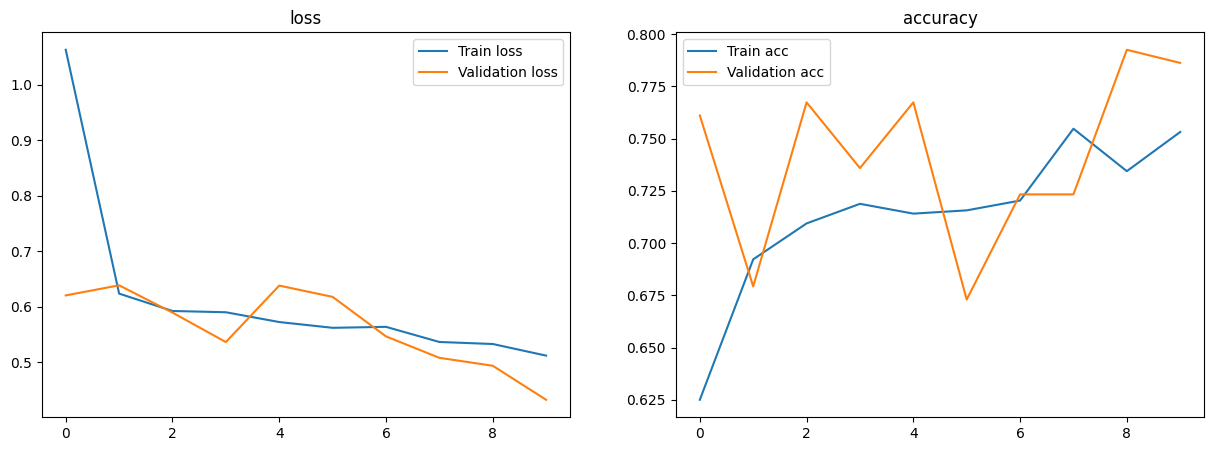

In [78]:
plot_history(history2)

In [79]:


model_3 = Sequential()


# Data Augmentation Layers

model_3.add(layers.RandomFlip("horizontal"))
model_3.add(layers.RandomZoom(0.1))
model_3.add(layers.RandomTranslation(0.2, 0.2))
model_3.add(layers.RandomRotation(0.1))



# Convolutional Layers

model_3.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same", input_shape=(img_height, img_width, 1)))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_3.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_3.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_3.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_3.add(layers.Flatten())

model_3.add(layers.Dense(64, activation="relu"))


model_3.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



#This callback will save the model to a file after every epoch
model_checkpoint = callbacks.ModelCheckpoint("model_best.keras", monitor='val_loss', verbose=0, save_best_only=True)

#This callback reduces the learning rate when a metric has stopped improving.
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

#This callback will stop the training if the monitored metric (in this case, validation loss) does not improve.
early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)




# Train the model
history3 = model_3.fit(dataset, validation_data=validation_dataset, epochs=1000,batch_size=32, callbacks=[model_checkpoint, lr_reducer, early_stopper])        



# Evaluate the model
loss, accuracy = model_3.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5352 - loss: 2.6222 - val_accuracy: 0.7233 - val_loss: 0.6413 - learning_rate: 0.0010
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6938 - loss: 0.6573 - val_accuracy: 0.7296 - val_loss: 0.5713 - learning_rate: 0.0010
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7256 - loss: 0.5802 - val_accuracy: 0.7296 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7159 - loss: 0.5530 - val_accuracy: 0.7610 - val_loss: 0.4815 - learning_rate: 0.0010
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7603 - loss: 0.4863 - val_accuracy: 0.7484 - val_loss: 0.5215 - learning_rate: 0.0010
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7463 - loss: 0.5261 - val_accuracy: 0.7673 - val_loss: 0.5258 - learning_rate: 0.0010
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7409 - loss: 0.

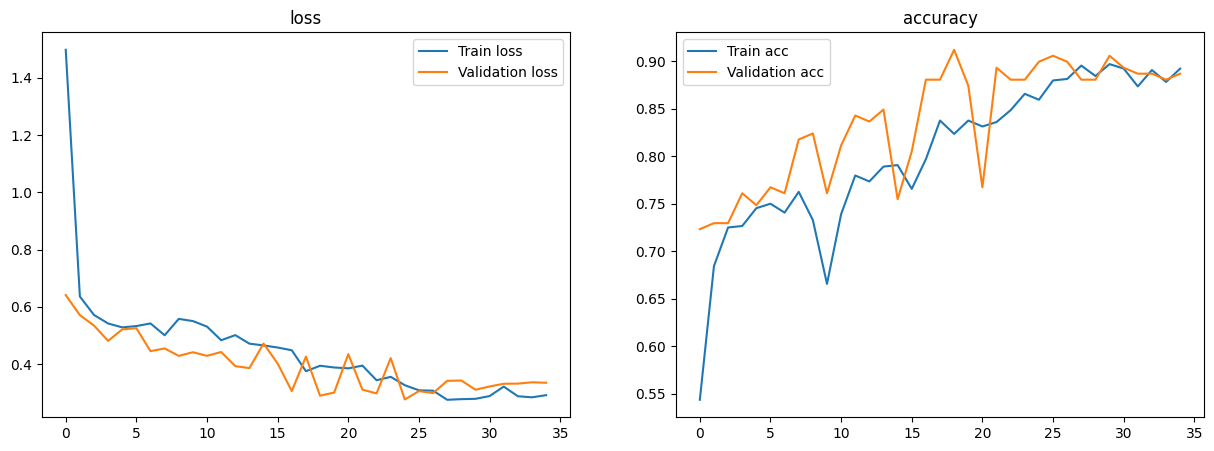

In [80]:
plot_history(history3)

In [81]:
# Evaluate the model on test_dataset
loss, accuracy = model_3.evaluate(test_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8374 - loss: 0.4214
Validation Loss: 0.4596765637397766
Validation Accuracy: 0.8199999928474426


## EfficientNetB0

In [88]:
training_path = '/kaggle/input/breast-lesion-dataset2/Breast_lesion_dataset2/Training_data'

# parameters for the dataset generation
batch_size = 32
img_height = 224  # what should the input size be? #224
img_width = 224   # ?

# Create training dataset from directory
dataset_rgb = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='int',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
    validation_split=0.2,  # image proportion for validation
    subset='training',
)

# Crreating validation set
validation_dataset_rgb  = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='int',
    class_names=['benign', 'malignant'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)


# Load the test dataset
test_dataset_rgb  = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    shuffle=True,
    image_size=(224, 224), 
    color_mode='rgb', 
    batch_size=32)  

Found 799 files belonging to 2 classes.
Using 640 files for training.
Found 799 files belonging to 2 classes.
Using 159 files for validation.
Found 100 files belonging to 2 classes.


In [135]:
from tensorflow.keras import Input
from tensorflow.keras.applications import EfficientNetV2B2

# Parameters for the dataset and model
batch_size = 64
num_classes = 2  # binary classification (benign vs malignant)


input_tensor=Input(shape=(img_height, img_width, 3))

x=layers.RandomFlip("horizontal")(input_tensor)
x=layers.RandomZoom([0.1, 0.3] )(x) 
x=layers.RandomTranslation(0.3, 0.3)(x) 
x=layers.RandomRotation([-1,1])(x)



#x=layers.RandomFlip("horizontal")(input_tensor)
#x=layers.RandomZoom(0.1)(x)
#x=layers.RandomTranslation(0.2, 0.2)(x)
#x=layers.RandomRotation(0.1)(x)



# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_tensor=input_tensor)(x)

# Freeze the pre-trained layers
base_model.trainable = False


# Add custom classification head
x = GlobalAveragePooling2D()(base_model)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='sigmoid')(x)



# Create the model
model_eff = Model(inputs=input_tensor, outputs=output)

# Compile the model
model_eff.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Display the model summary
model_eff.summary()

# Assuming you have defined your training and validation datasets
# Replace `train_dataset` and `val_dataset` with your actual datasets



#This callback will save the model to a file after every epoch
model_checkpoint = callbacks.ModelCheckpoint("model_best.keras", monitor='val_loss', verbose=0, save_best_only=True)

#This callback reduces the learning rate when a metric has stopped improving.
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

#This callback will stop the training if the monitored metric (in this case, validation loss) does not improve.
early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)





# Train the model

history_eff_improved= model_eff.fit(dataset_rgb,
                    validation_data=validation_dataset_rgb,
                    epochs=50,  batch_size=batch_size, callbacks=[model_checkpoint, lr_reducer, early_stopper]
                          )

# Evaluate the model
loss, accuracy = model_eff.evaluate(validation_dataset_rgb)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Model: "functional_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_18 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_18 (RandomZoom)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_17           │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_17              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,949,984 (34.14 MB)

 Trainable params: 8,867,696 (33.83 MB)

 Non-trainable params: 82,288 (321.44 KB)

Epoch 1/50


2024-05-08 12:24:14.298436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_130_1/efficientnetv2-b2_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 521ms/step - accuracy: 0.6111 - loss: 0.6387 - val_accuracy: 0.6038 - val_loss: 0.6381 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.8382 - loss: 0.3813 - val_accuracy: 0.8931 - val_loss: 0.3291 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.8954 - loss: 0.2668 - val_accuracy: 0.8616 - val_loss: 0.3230 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.8960 - loss: 0.2812 - val_accuracy: 0.7925 - val_loss: 0.4293 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.8627 - loss: 0.2896 - val_accuracy: 0.8805 - val_loss: 0.3455 - learning_rate: 1.0000e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.9245 - loss: 0.2270 - val_accuracy: 0.8868 - val_loss: 0.2932 - learning_rate: 1.0000e-04
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.9010 - l

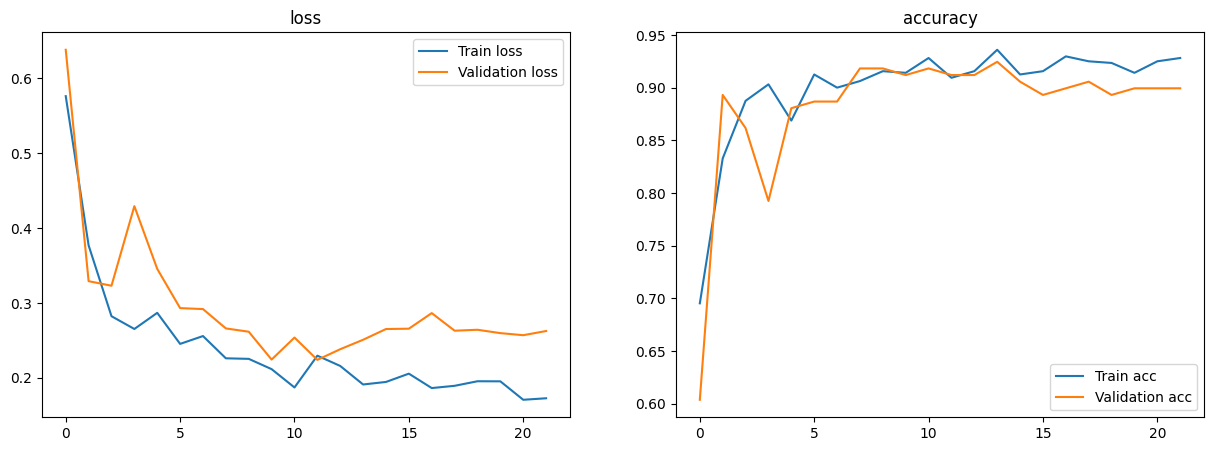

In [136]:
plot_history(history_eff_improved)


In [137]:

# Evaluate the model on test_dataset
loss, accuracy = model_eff.evaluate(test_dataset_rgb)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8852 - loss: 0.2792
Test Loss: 0.27165067195892334
Test Accuracy: 0.8899999856948853


## VGG16 model